This notebook calculates the SNR of LBG x CMB Lensing, assuming LSST u,g,r dropouts and Simons Observatory baseline CMB lensing noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from src.constants import *

In [2]:
# Define function to create Gaussian redshift distributions from mean and FWHM
def gaussian(z: np.ndarray, mu: float, fwhm: float) -> np.ndarray:
    sig = fwhm / 2.355
    return np.exp(-(z - mu)**2 / (2 * sig**2)) / np.sqrt(2 * np.pi * sig**2)

In [3]:
# Use LCDM cosmology
cosmo = ccl.CosmologyVanillaLCDM()

# Create a redshift grid
z = np.linspace(1, 7, 1000)

# Create all tracers
b_u = np.full_like(z, 4.0)
mu_u = 3
fwhm_u = 0.61
nz_u = gaussian(z, mu_u, fwhm_u)
udrop = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz_u), bias=(z, b_u))

b_g = np.full_like(z, 3.2)
mu_g = 4
fwhm_g = 0.68
nz_g = gaussian(z, mu_g, fwhm_g)
gdrop = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz_g), bias=(z, b_g))

b_r = np.full_like(z, 5.4)
mu_r = 5
fwhm_r = 0.80
nz_r = gaussian(z, mu_r, fwhm_r)
rdrop = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz_r), bias=(z, b_r))

cmb_lensing = ccl.CMBLensingTracer(cosmo, z_source=1100)

# Load SO CMB Lensing baseline noise curve
lensing_noise = np.genfromtxt("data/nlkk_v3_1_0_deproj0_SENS1_fsky0p4_it_lT30-3000_lP30-5000.dat")
ell = lensing_noise[:, 0]
Nkk = lensing_noise[:, 7]

# Calculate all angular power spectra
Cuu = ccl.angular_cl(cosmo, udrop, udrop, ell)
Cgg = ccl.angular_cl(cosmo, gdrop, gdrop, ell)
Crr = ccl.angular_cl(cosmo, rdrop, rdrop, ell)
Ckk = ccl.angular_cl(cosmo, cmb_lensing, cmb_lensing, ell)

Cku = ccl.angular_cl(cosmo, cmb_lensing, udrop, ell)
Ckg = ccl.angular_cl(cosmo, cmb_lensing, gdrop, ell)
Ckr = ccl.angular_cl(cosmo, cmb_lensing, rdrop, ell)

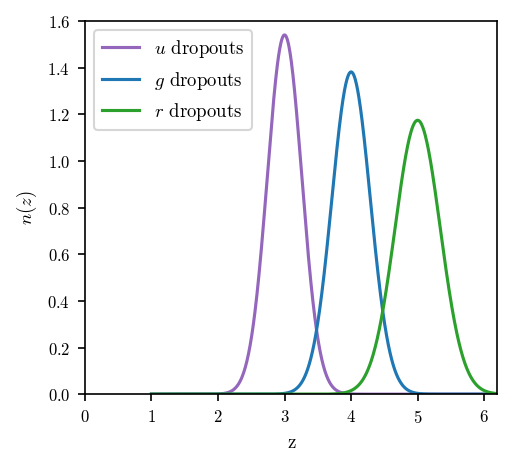

In [4]:
# Plot redshift distributions
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

ax.plot(z, nz_u, c=color_u, label="$u$ dropouts")
ax.plot(z, nz_g, c=color_g, label="$g$ dropouts")
ax.plot(z, nz_r, c=color_r, label="$r$ dropouts")
ax.legend()
ax.set(xlabel="z", ylabel="$n(z)$", xlim=(0, 6.2), ylim=(0, 1.6))

fig.savefig("figures/fiducial_redshift_distributions.pdf")

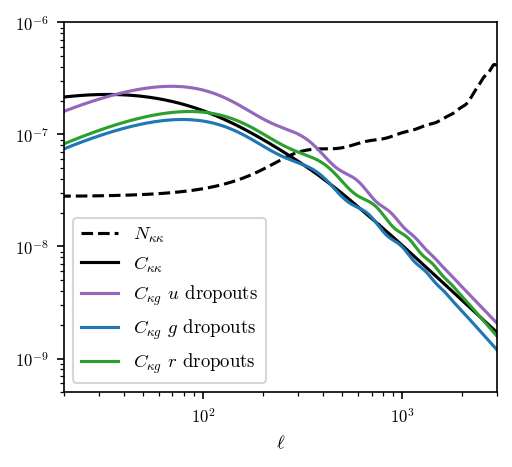

In [5]:
# Plot all cross-spectra with lensing noise
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

ax.plot(ell, Nkk, c="k", ls="--", label="$N_{\kappa \kappa}$")
ax.plot(ell, Ckk, c="k", label="$C_{\kappa \kappa}$")

ax.plot(ell, Cku, c=color_u, label="$C_{\kappa g}$ $u$ dropouts")
ax.plot(ell, Ckg, c=color_g, label="$C_{\kappa g}$ $g$ dropouts")
ax.plot(ell, Ckr, c=color_r, label="$C_{\kappa g}$ $r$ dropouts")

ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlim=(20, 3_000),
    ylim=(5e-10, 1e-6),
    xlabel="$\ell$",
)

fig.savefig("figures/cmb_xcorr.pdf")

In [6]:
# Grid of number densities
n = np.geomspace(1e-3, 1e5, 10_000)

# Calculate SNR as a function of number density
var_u = ((Ckk + Nkk) * (Cuu + 1 / (n[:, None] * deg2_per_ster)) + Cku**2) / (2 * ell + 1) / fwfd
snr_u = np.sqrt(np.sum(Cku**2 / var_u, axis=1))

var_g = ((Ckk + Nkk) * (Cgg + 1 / (n[:, None] * deg2_per_ster)) + Ckg**2) / (2 * ell + 1) / fwfd
snr_g = np.sqrt(np.sum(Ckg**2 / var_g, axis=1))

var_r = ((Ckk + Nkk) * (Crr + 1 / (n[:, None] * deg2_per_ster)) + Ckr**2) / (2 * ell + 1) / fwfd
snr_r = np.sqrt(np.sum(Ckr**2 / var_r, axis=1))

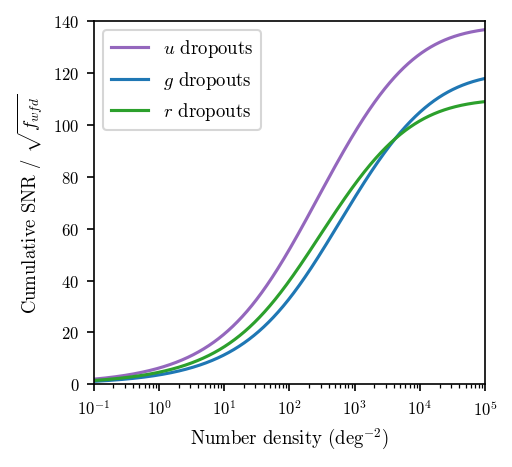

In [7]:
# Plot SNR vs number density
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

ax.plot(n, snr_u, c=color_u, label="$u$ dropouts")
ax.plot(n, snr_g, c=color_g, label="$g$ dropouts")
ax.plot(n, snr_r, c=color_r, label="$r$ dropouts")

ax.legend()
ax.set(
    xlabel="Number density (deg$^{-2}$)",
    ylabel="Cumulative SNR / $\sqrt{f_{wfd}}$",
    xscale="log",
    xlim=(1e-1, 1e5),
    ylim=(0, 140),
)

fig.savefig("figures/cmb_xcorr_snr.pdf")

In [8]:
np.savez("data/cmb_xcorr_snr_vals.npz", n=n, snr_u=snr_u, snr_g=snr_g, snr_r=snr_r)